In [1]:
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet

In [2]:
class EncoderEfficientNetB5(nn.Module):
    def __init__(self, pretrained=True):
        super(EncoderEfficientNetB5, self).__init__()
        # Load EfficientNet-B5
        self.encoder = EfficientNet.from_pretrained('efficientnet-b5') if pretrained else EfficientNet.from_name('efficientnet-b5')
        # Extract blocks (stages)
        self.blocks = self.encoder._blocks
        
    def forward(self, x):
        # Store features from different stages
        features = []
        x = self.encoder._conv_stem(x)  # Initial convolution
        x = self.encoder._bn0(x)       # Batch normalization
        for block in self.blocks:
            x = block(x)
            features.append(x)         # Save intermediate features
        return features


In [3]:
class DecoderFPN(nn.Module):
    def __init__(self, encoder_channels, decoder_channels):
        super(DecoderFPN, self).__init__()
        self.up_convs = nn.ModuleList()
        self.lat_convs = nn.ModuleList()

        # Build lateral and upsampling convolutions
        for in_channels in encoder_channels:
            self.lat_convs.append(nn.Conv2d(in_channels, decoder_channels, kernel_size=1))
            self.up_convs.append(nn.Conv2d(decoder_channels, decoder_channels, kernel_size=3, padding=1))
        
    def forward(self, encoder_features):
        # Start from the deepest feature and go upwards
        x = self.lat_convs[-1](encoder_features[-1])  # Lateral convolution for the deepest feature
        outputs = [x]  # Collect outputs

        # Iterate through the encoder features in reverse order
        for i in range(len(encoder_features) - 2, -1, -1):
            x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)  # Upsample
            lateral = self.lat_convs[i](encoder_features[i])  # Apply lateral convolution
            x = x + lateral  # Add lateral and upsampled feature
            x = self.up_convs[i](x)  # Apply up convolution
            outputs.append(x)
        
        return outputs[::-1]  # Reverse to match spatial resolution order


In [4]:
class EfficientNetFPN(nn.Module):
    def __init__(self, num_classes, encoder_channels, decoder_channels=256):
        super(EfficientNetFPN, self).__init__()
        self.encoder = EncoderEfficientNetB5(pretrained=True)
        self.decoder = DecoderFPN(encoder_channels, decoder_channels)
        self.final_conv = nn.Conv2d(decoder_channels, num_classes, kernel_size=1)  # Final 1x1 convolution

    def forward(self, x):
        encoder_features = self.encoder(x)
        decoder_features = self.decoder(encoder_features)
        x = decoder_features[0]  # Use the highest-resolution output
        x = self.final_conv(x)
        return x


In [5]:
# Encoder channels for EfficientNet-B5
encoder_channels = [48, 144, 240, 384, 2048]  # Output channels from each stage

# Initialize the model
model = EfficientNetFPN(num_classes=1, encoder_channels=encoder_channels) #num_classes = 2?


Loaded pretrained weights for efficientnet-b5


In [6]:
import torch
import torch.nn as nn

class BCEWithLogitsLossCustom(nn.Module):
    def __init__(self):
        super(BCEWithLogitsLossCustom, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()  # Automatically applies sigmoid

    def forward(self, inputs, targets):
        return self.bce_loss(inputs, targets)

# Example usage:
# loss_fn = BCEWithLogitsLossCustom()
# loss = loss_fn(output, target)


In [7]:
class BCEFocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(BCEFocalLoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss(reduction='none')
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Flatten the inputs and targets
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        # Compute BCE loss
        bce_loss = self.bce_loss(inputs, targets)

        # Compute Focal Loss modulation factor
        pt = torch.exp(-bce_loss)  # Probability of the true class
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Example usage:
# combined_loss = BCEFocalLoss(alpha=0.25, gamma=2)
# loss = combined_loss(output, target)


In [19]:
import os
import nibabel as nib

def check_files(images_path, masks_path):
    issues_found = False
    
    # Get all case folders
    image_case_folders = sorted(os.listdir(images_path))
    mask_case_folders = sorted(os.listdir(masks_path))

    print("Checking case folders...")

    # Ensure that the case folder structure matches in both images and masks
    if image_case_folders != mask_case_folders:
        print("Mismatch between image and mask folder structures!")
        return
    
    for case_folder in image_case_folders:
        print(f"\nProcessing case folder: {case_folder}")
        
        image_case_path = os.path.join(images_path, case_folder)
        mask_case_path = os.path.join(masks_path, case_folder)
        
        # Ensure that both the image and mask directories exist
        if not os.path.isdir(image_case_path):
            print(f"Missing image folder: {image_case_path}")
            issues_found = True
            continue
        if not os.path.isdir(mask_case_path):
            print(f"Missing mask folder: {mask_case_path}")
            issues_found = True
            continue
        
        # Check for image files in the folder
        image_files = [f for f in os.listdir(image_case_path) if f.endswith('.nii.gz')]
        mask_files = [f for f in os.listdir(mask_case_path) if f.endswith('.nii.gz')]

        # Check if image files are present
        if not image_files:
            print(f"No image files found in {image_case_path}")
            issues_found = True
        else:
            for image_file in image_files:
                image_path = os.path.join(image_case_path, image_file)
                #print(f"  Checking image file: {image_file}")
                try:
                    image = nib.load(image_path)
                    if image.get_fdata().size == 0:
                        print(f"  Empty image data in {image_path}")
                        issues_found = True
                except Exception as e:
                    print(f"  Error loading image {image_path}: {str(e)}")
                    issues_found = True

        # Check if mask files are present
        if not mask_files:
            print(f"No mask files found in {mask_case_path}")
            issues_found = True
        else:
            for mask_file in mask_files:
                mask_path = os.path.join(mask_case_path, mask_file)
                #print(f"  Checking mask file: {mask_file}")
                try:
                    mask = nib.load(mask_path)
                    if mask.get_fdata().size == 0:
                        print(f"  Empty mask data in {mask_path}")
                        issues_found = True
                except Exception as e:
                    print(f"  Error loading mask {mask_path}: {str(e)}")
                    issues_found = True

    if not issues_found:
        print("\nAll files seem to be in order!")

# Example usage:
images_path = "E:/kits23/2d_slices/images/"
masks_path = "E:/kits23/2d_slices/masks/"
check_files(images_path, masks_path)


Checking case folders...

Processing case folder: 00000

Processing case folder: 00001

Processing case folder: 00002

Processing case folder: 00003

Processing case folder: 00004

Processing case folder: 00005

Processing case folder: 00006

Processing case folder: 00007

Processing case folder: 00008

Processing case folder: 00009

Processing case folder: 00010

Processing case folder: 00011

Processing case folder: 00012

Processing case folder: 00013

Processing case folder: 00014

Processing case folder: 00015

Processing case folder: 00016

Processing case folder: 00017

Processing case folder: 00018

Processing case folder: 00019

Processing case folder: 00020

Processing case folder: 00021

Processing case folder: 00022

Processing case folder: 00023

Processing case folder: 00024

Processing case folder: 00025

Processing case folder: 00026

Processing case folder: 00027

Processing case folder: 00028

Processing case folder: 00029

Processing case folder: 00030

Processing ca

In [12]:
import os
import nibabel as nib

# Define the paths
images_path = "E:/kits23/2d_slices/images/"
masks_path = "E:/kits23/2d_slices/masks/"

# Function to check dimensions of images and masks
def check_image_mask_dimensions(images_path, masks_path):
    image_case_folders = sorted(os.listdir(images_path))  # Sort image case folders
    mask_case_folders = sorted(os.listdir(masks_path))    # Sort mask case folders

    # Loop through a few cases to check dimensions
    for case_folder in image_case_folders[:5]:  # Check first 5 cases, adjust as needed
        image_case_path = os.path.join(images_path, case_folder)
        mask_case_path = os.path.join(masks_path, case_folder)

        # Get image and mask files inside the case folder (they should be .nii.gz files)
        image_files = sorted([f for f in os.listdir(image_case_path) if f.endswith('.nii.gz')])
        mask_files = sorted([f for f in os.listdir(mask_case_path) if f.endswith('.nii.gz')])

        if not image_files or not mask_files:
            print(f"Warning: No valid .nii.gz files found in {image_case_path} or {mask_case_path}")
            continue

        # Load image and mask (assuming 1:1 correspondence between slices)
        image = nib.load(os.path.join(image_case_path, image_files[0])).get_fdata()
        mask = nib.load(os.path.join(mask_case_path, mask_files[0])).get_fdata()

        # Print the dimensions
        print(f"Case Folder: {case_folder}")
        print(f"Image shape: {image.shape}")
        print(f"Mask shape: {mask.shape}")
        print("-" * 50)

# Check dimensions of images and masks
check_image_mask_dimensions(images_path, masks_path)


Case Folder: 00000
Image shape: (1, 512, 512)
Mask shape: (1, 512, 512)
--------------------------------------------------
Case Folder: 00001
Image shape: (1, 512, 512)
Mask shape: (1, 512, 512)
--------------------------------------------------
Case Folder: 00002
Image shape: (1, 512, 512)
Mask shape: (1, 512, 512)
--------------------------------------------------
Case Folder: 00003
Image shape: (1, 512, 512)
Mask shape: (1, 512, 512)
--------------------------------------------------
Case Folder: 00004
Image shape: (1, 512, 512)
Mask shape: (1, 512, 512)
--------------------------------------------------


In [16]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import KFold
import nibabel as nib
import numpy as np
from tqdm import tqdm
from torchvision import transforms
from efficientnet_pytorch import EfficientNet
import torch.nn.functional as F

# Dataset class for loading the 2D slices and masks
class KidneyDataset(Dataset):
    def __init__(self, image_dir, mask_dir, case_folders, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.case_folders = case_folders
        self.transform = transform
    
    def __len__(self):
        return len(self.case_folders)
    
    def __getitem__(self, idx):
        case_folder = self.case_folders[idx]
        # Load images and masks for each case folder
        images = sorted(os.listdir(os.path.join(self.image_dir, case_folder)))
        masks = sorted(os.listdir(os.path.join(self.mask_dir, case_folder)))
        
        # Read the .nii.gz files and convert them to numpy arrays
        image_stack = []
        mask_stack = []
        for img, mask in zip(images, masks):
            img_data = nib.load(os.path.join(self.image_dir, case_folder, img)).get_fdata()
            mask_data = nib.load(os.path.join(self.mask_dir, case_folder, mask)).get_fdata()
            image_stack.append(img_data)
            mask_stack.append(mask_data)
        
        # Convert lists to numpy arrays and ensure correct shape
        image_stack = np.stack(image_stack, axis=0)
        mask_stack = np.stack(mask_stack, axis=0)
        
        # Convert to torch tensors
        image_tensor = torch.tensor(image_stack, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
        mask_tensor = torch.tensor(mask_stack, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
        
        if self.transform:
            image_tensor = self.transform(image_tensor)
            mask_tensor = self.transform(mask_tensor)
        
        return image_tensor, mask_tensor

# Model architecture (already provided by you)
class EncoderEfficientNetB5(nn.Module):
    def __init__(self, pretrained=True):
        super(EncoderEfficientNetB5, self).__init__()
        self.encoder = EfficientNet.from_pretrained('efficientnet-b5') if pretrained else EfficientNet.from_name('efficientnet-b5')
        self.blocks = self.encoder._blocks
    
    def forward(self, x):
        features = []
        x = self.encoder._conv_stem(x)
        x = self.encoder._bn0(x)
        for block in self.blocks:
            x = block(x)
            features.append(x)
        return features

class DecoderFPN(nn.Module):
    def __init__(self, encoder_channels, decoder_channels=256):
        super(DecoderFPN, self).__init__()
        self.up_convs = nn.ModuleList()
        self.lat_convs = nn.ModuleList()
        for in_channels in encoder_channels:
            self.lat_convs.append(nn.Conv2d(in_channels, decoder_channels, kernel_size=1))
            self.up_convs.append(nn.Conv2d(decoder_channels, decoder_channels, kernel_size=3, padding=1))
    
    def forward(self, encoder_features):
        x = self.lat_convs[-1](encoder_features[-1])
        outputs = [x]
        for i in range(len(encoder_features) - 2, -1, -1):
            x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
            lateral = self.lat_convs[i](encoder_features[i])
            x = x + lateral
            x = self.up_convs[i](x)
            outputs.append(x)
        return outputs[::-1]

class EfficientNetFPN(nn.Module):
    def __init__(self, num_classes, encoder_channels, decoder_channels=256):
        super(EfficientNetFPN, self).__init__()
        self.encoder = EncoderEfficientNetB5(pretrained=True)
        self.decoder = DecoderFPN(encoder_channels, decoder_channels)
        self.final_conv = nn.Conv2d(decoder_channels, num_classes, kernel_size=1)
    
    def forward(self, x):
        encoder_features = self.encoder(x)
        decoder_features = self.decoder(encoder_features)
        x = decoder_features[0]
        x = self.final_conv(x)
        return x

# Loss function (provided by you)
class BCEWithLogitsLossCustom(nn.Module):
    def __init__(self):
        super(BCEWithLogitsLossCustom, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()

    def forward(self, inputs, targets):
        return self.bce_loss(inputs, targets)

# Training function
def train_model(model, train_loader, val_loader, num_epochs=50, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = BCEWithLogitsLossCustom()
    best_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
            optimizer.zero_grad()
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}")
        
        # Validation loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch+1}/{num_epochs} - Validation Loss: {avg_val_loss:.4f}")
        
        # Save the model with the best validation loss
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"Model saved with val loss: {best_loss:.4f}")

# Cross-validation function
def cross_validate(image_dir, mask_dir, k=5, num_epochs=50, lr=0.001):
    # Get the list of all case folders
    case_folders = sorted(os.listdir(image_dir))
    
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold = 1
    
    for train_idx, val_idx in kf.split(case_folders):
        print(f"\nTraining fold {fold}/{k}...")
        
        # Create datasets and dataloaders for the current fold
        train_folders = [case_folders[i] for i in train_idx]
        val_folders = [case_folders[i] for i in val_idx]
        
        train_dataset = KidneyDataset(image_dir, mask_dir, train_folders, transform=None)
        val_dataset = KidneyDataset(image_dir, mask_dir, val_folders, transform=None)
        
        train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
        
        # Initialize the model
        model = EfficientNetFPN(num_classes=1, encoder_channels=[32, 16, 8, 4, 2])  # Adjust channels
        model.to(device)
        
        # Train the model
        train_model(model, train_loader, val_loader, num_epochs, lr)
        fold += 1

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Start cross-validation
cross_validate('E:/kits23/2d_slices/images/', 'E:/kits23/2d_slices/masks/')



Training fold 1/5...
Loaded pretrained weights for efficientnet-b5


RuntimeError: stack expects each tensor to be equal size, but got [235, 1, 1, 512, 512] at entry 0 and [265, 1, 1, 512, 512] at entry 1

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3

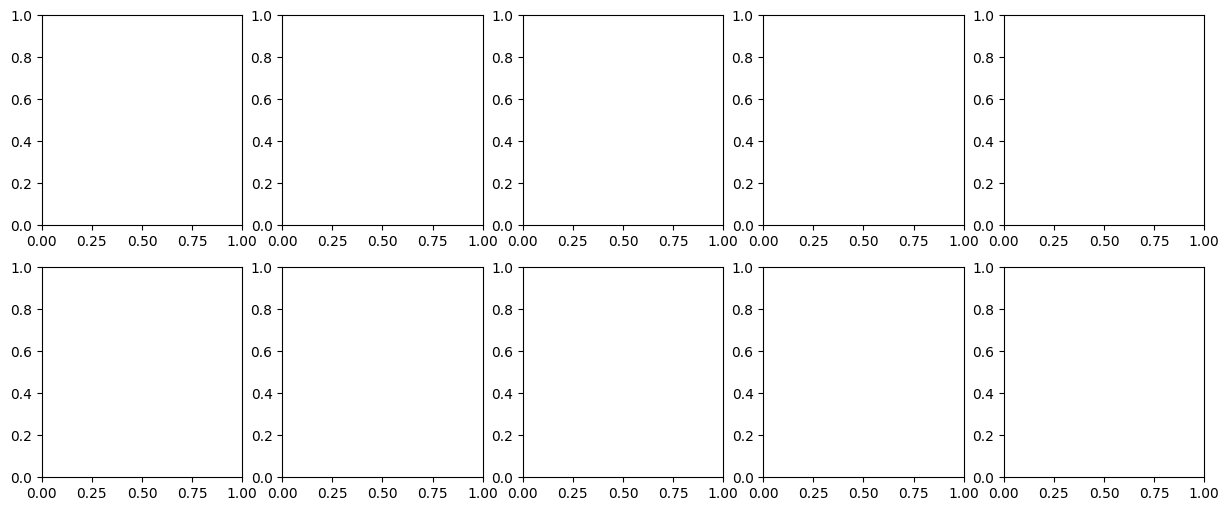

In [11]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

# Assuming the KidneyDataset class is already defined and dataset is available
# Assuming you have a dataset object created as 'train_dataset'

# Create a DataLoader for the dataset (batch size of 1 since we want to view individual images)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)

# Function to plot the first 10 images
def visualize_images(dataset_loader, num_images=10):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # Create a grid for 10 images (2 rows, 5 columns)
    axes = axes.flatten()

    for i, (image, mask) in enumerate(dataset_loader):
        if i >= num_images:
            break
        
        # Convert the image tensor to a numpy array for visualization (shape: [3, H, W] -> [H, W, 3])
        image = image.squeeze(0).permute(1, 2, 0).numpy()  # Remove the batch dimension and permute channels
        
        # Plot the image
        axes[i].imshow(image.astype('uint8'))  # Cast to uint8 to make sure the image is displayed correctly
        axes[i].axis('off')  # Remove axis ticks
        axes[i].set_title(f"Image {i+1}")

    plt.tight_layout()
    plt.show()

# Visualize the first 10 images from the train_loader
visualize_images(train_loader, num_images=10)


In [19]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.optim import Adam
from tqdm import tqdm
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model, loss function, and other necessary components
class BCEWithLogitsLossCustom(nn.Module):
    def __init__(self):
        super(BCEWithLogitsLossCustom, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()

    def forward(self, inputs, targets):
        return self.bce_loss(inputs, targets)

# Dataset Class for 2D slices
class KidneyDataset(Dataset):
    def __init__(self, images_path, masks_path, transform=None):
        self.images_path = images_path
        self.masks_path = masks_path
        self.transform = transform
        self.image_case_folders = sorted(os.listdir(images_path))  # Sort image case folders
        self.mask_case_folders = sorted(os.listdir(masks_path))    # Sort mask case folders

        # Ensure number of images and masks match
        assert len(self.image_case_folders) == len(self.mask_case_folders), "Mismatch between image and mask count!"
        
        # Ensure folders are valid: skip folders with no corresponding mask
        self.valid_folders = [
            folder for folder in self.image_case_folders
            if folder in self.mask_case_folders
        ]

    def __len__(self):
        return len(self.valid_folders)

    def __getitem__(self, idx):
        case_folder = self.valid_folders[idx]  # Use valid folders
        image_case_path = os.path.join(self.images_path, case_folder)
        mask_case_path = os.path.join(self.masks_path, case_folder)

        # Get image and mask files inside the case folder (they should be .nii.gz files)
        image_files = sorted([f for f in os.listdir(image_case_path) if f.endswith('.nii.gz')])
        mask_files = sorted([f for f in os.listdir(mask_case_path) if f.endswith('.nii.gz')])

        if not image_files or not mask_files:
            print(f"Warning: No files found in {image_case_path} or {mask_case_path} for index {idx}")
            raise ValueError(f"No valid .nii.gz files found in {image_case_path} or {mask_case_path}")

        # Load the first image and mask files
        image = nib.load(os.path.join(image_case_path, image_files[0])).get_fdata()
        mask = nib.load(os.path.join(mask_case_path, mask_files[0])).get_fdata()

        # Squeeze any singleton dimensions
        image = np.squeeze(image)
        mask = np.squeeze(mask)

        # Convert to torch tensors
        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32)

        # Replicate the image to 3 channels (single-channel image to 3-channel)
        image = image.unsqueeze(0).repeat(3, 1, 1)  # Shape (1, H, W) -> (3, H, W)

        # Apply any transforms (if provided)
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        # Ensure the shape is [B, C, H, W] (batch size, channels, height, width)
        return image.unsqueeze(0), mask.unsqueeze(0)  # Add batch dimension

# Save Checkpoint
def save_checkpoint(model, optimizer, epoch, loss, checkpoint_dir="checkpoints"):
    os.makedirs(checkpoint_dir, exist_ok=True)  # Ensure directory exists
    checkpoint_filename = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pt")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, checkpoint_filename)
    print(f"Checkpoint saved at {checkpoint_filename}")

# Load Checkpoint
def load_checkpoint(model, optimizer, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Resuming training from epoch {epoch} with loss {loss}")
    return epoch, loss

# Model Training Code
def train_model(model, train_loader, valid_loader, num_epochs, learning_rate, checkpoint_dir="checkpoints", save_dir="predictions"):
    optimizer = Adam(model.parameters(), lr=learning_rate)
    criterion = BCEWithLogitsLossCustom()

    os.makedirs(save_dir, exist_ok=True)  # For saving predictions

    # Start training
    epoch = 0
    loss = float('inf')
    
    # Ensure checkpoints directory exists
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # Try loading checkpoint if exists
    latest_checkpoint = None
    for checkpoint_file in os.listdir(checkpoint_dir):
        if checkpoint_file.endswith(".pt"):
            latest_checkpoint = os.path.join(checkpoint_dir, checkpoint_file)

    if latest_checkpoint:
        epoch, loss = load_checkpoint(model, optimizer, latest_checkpoint)
    else:
        epoch = 0  # Start fresh
    
    for current_epoch in range(epoch, num_epochs):
        model.train()
        running_loss = 0.0

        for images, masks in tqdm(train_loader, desc=f"Epoch {current_epoch + 1}/{num_epochs}"):
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = criterion(outputs, masks)
            optimizer.zero_grad()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {current_epoch + 1} Loss: {running_loss / len(train_loader)}")

        # Save predictions and model checkpoint
        model.eval()
        with torch.no_grad():
            for images, masks in valid_loader:
                images = images.to(device)
                masks = masks.to(device)
                outputs = model(images)

                # Save the predicted images
                for i in range(images.size(0)):
                    pred_image = torch.sigmoid(outputs[i]).cpu().numpy()
                    pred_image = np.squeeze(pred_image)  # Remove channel dimension
                    pred_image = np.round(pred_image)  # Threshold for binary mask
                    save_image(pred_image, current_epoch, i)

        save_checkpoint(model, optimizer, current_epoch + 1, running_loss / len(train_loader))

def save_image(image, epoch, index, save_dir="predictions"):
    file_name = os.path.join(save_dir, f"epoch_{epoch}_pred_{index}.png")
    plt.imshow(image, cmap="gray")
    plt.savefig(file_name)
    plt.close()

# Main Training Process
if __name__ == "__main__":
    # Paths
    images_path = "E:/kits23/2d_slices/images/"
    masks_path = "E:/kits23/2d_slices/masks/"

    # Hyperparameters
    num_epochs = 50
    learning_rate = 0.001
    batch_size = 2

    # Data Loaders
    transform = None  # No need to convert image to tensor here
    train_dataset = KidneyDataset(images_path, masks_path, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model
    model = EfficientNetFPN(num_classes=1, encoder_channels=[32, 64, 128, 256, 512], decoder_channels=256).to(device)

    # Start Training
    train_model(model, train_loader, valid_loader, num_epochs, learning_rate)


Loaded pretrained weights for efficientnet-b5


Epoch 1/50:   0%|          | 0/245 [00:02<?, ?it/s]


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [2, 1, 3, 513, 513]

In [ ]:
import os
import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.optim import Adam
import nibabel as nib
from torchvision import transforms
from tqdm import tqdm

# Assuming the EfficientNetFPN model is already defined and imported
# Assuming KidneyDataset class is already defined and imported

# Hyperparameters
batch_size = 2
num_epochs = 50
learning_rate = 0.001
image_dir = 'E:/kits23/2d_slices/images/'  # Path to images
mask_dir = 'E:/kits23/2d_slices/masks/'    # Path to masks
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the transformation (if needed)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

# Initialize the dataset and DataLoader
train_dataset = KidneyDataset(image_dir, mask_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Validation dataset (if you have separate validation data)
# validation_dataset = KidneyDataset(val_image_dir, val_mask_dir, transform=transform)
# valid_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

# Initialize your model
model = EfficientNetFPN(num_classes=1, encoder_channels=[32, 64, 128, 256, 512], decoder_channels=256).to(device)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy with logits
optimizer = Adam(model.parameters(), lr=learning_rate)

# Function for training the model
def train_model(model, train_loader, num_epochs, learning_rate):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        # Iterate through the training data
        for images, masks in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            
            # Calculate loss
            loss = criterion(outputs, masks)
            running_loss += loss.item()

            # Backpropagation and optimization
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            outputs = torch.sigmoid(outputs)  # Sigmoid activation to get probabilities
            predicted = (outputs > 0.5).float()  # Threshold at 0.5 to get binary mask
            correct_predictions += (predicted == masks).sum().item()
            total_predictions += masks.numel()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct_predictions / total_predictions

        print(f'Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')
        
        # Optionally, save the model after each epoch
        # torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pth")

# Train the model
train_model(model, train_loader, num_epochs, learning_rate)


In [12]:
import torch
print(torch.cuda.is_available())  # This will print True if CUDA is available


False
